In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array

In [2]:
h, w = 160, 160

x_train=[]
y_train=[]
x_test=[]
y_test=[]

path_train_low='../../dataSets/ref/our485/low/'
path_train_high='../../dataSets/ref/our485/high/'
path_test_low='../../dataSets/ref/eval15/low/'
path_test_high='../../dataSets/ref/eval15/high/'

print('\nLoding Train dataset :')
i=0;
for img in os.listdir(path_train_low):
    img_low_path=os.path.join(path_train_low, img)
    img_high_path=os.path.join(path_train_high, img)
    
    img_low=load_img(img_low_path, target_size=(h,w))
    img_low=img_to_array(img_low)/255.
       
    i=i+1
    print("{:.2f}".format(i/4.89)+' %',end='\r')
    
    img_high=load_img(img_high_path, target_size=(h,w))
    img_high=img_to_array(img_high)/255.
    im=cv2.cvtColor(img_high,cv2.COLOR_RGB2HSV)
    
    x_train.append(img_low)
    y_train.append(np.expand_dims(im[:,:,2],-1))
    
print('\nLoding Test dataset :')
i=0;
for img in os.listdir(path_test_low):
    img_low_path=os.path.join(path_test_low, img)
    img_high_path=os.path.join(path_test_high, img)
    
    img_low=load_img(img_low_path, target_size=(h,w))
    img_low=img_to_array(img_low)/255.
   
    i=i+1
    print("{:.2f}".format(i/0.14)+' %',end='\r')
    
    img_high=load_img(img_high_path, target_size=(h,w))
    img_high=img_to_array(img_high)/255.
    im=cv2.cvtColor(img_high,cv2.COLOR_RGB2HSV)
    
    x_test.append(img_low)
    y_test.append(np.expand_dims(im[:,:,2],-1))

x_train=np.array(x_train, dtype="float32")
y_train=np.array(y_train, dtype="float32")

x_test=np.array(x_test, dtype="float32")
y_test=np.array(y_test, dtype="float32")


Loding Train dataset :
100.00 %
Loding Test dataset :


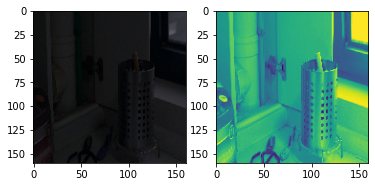

In [3]:
fig=plt.figure()

f=fig.add_subplot(1,2,1)
s=fig.add_subplot(1,2,2)

f.imshow(x_test[1])
s.imshow(y_test[1])

In [4]:
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input,add,Conv2D,MaxPooling2D,UpSampling2D,Flatten,Dropout,Dense,BatchNormalization,Reshape,UpSampling2D,Conv2DTranspose,Concatenate

def InstantiateModel(in_):
    channel = 32
    kernal_size = (3, 3)
    
    em_conv0 = Conv2D(channel, kernal_size, strides=1, padding='same', activation=None)(in_)
        
    em_conv1 = Conv2D(channel, kernal_size, strides=1, padding='same', activation='relu')(em_conv0)
    em_conv2 = Conv2D(channel, kernal_size, strides=1, padding='same', activation='relu')(em_conv1)+em_conv0
    em_conv3 = Conv2D(channel, kernal_size, strides=1, padding='same', activation='relu')(em_conv2)+em_conv1
    em_conv4 = Conv2D(channel, kernal_size, strides=1, padding='same', activation='relu')(em_conv3)+em_conv2
    em_conv5 = Conv2D(channel, kernal_size, strides=1, padding='same', activation='relu')(em_conv4)+em_conv3
    em_conv6 = Conv2D(channel, kernal_size, strides=1, padding='same', activation='relu')(em_conv5)+em_conv4
    
    em_model = Conv2D(3, (1,1), padding='same', activation=None)(em_conv6)
    
    return em_model

In [5]:
Input_Sample = Input(shape=(h, w, 3))
Output_ = InstantiateModel(Input_Sample)
model = Model(inputs=Input_Sample, outputs=Output_)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 160, 160, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 160, 160, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 160, 160, 32) 9248        conv2d_1[0][0]                   
_______________________________________________________________________________________

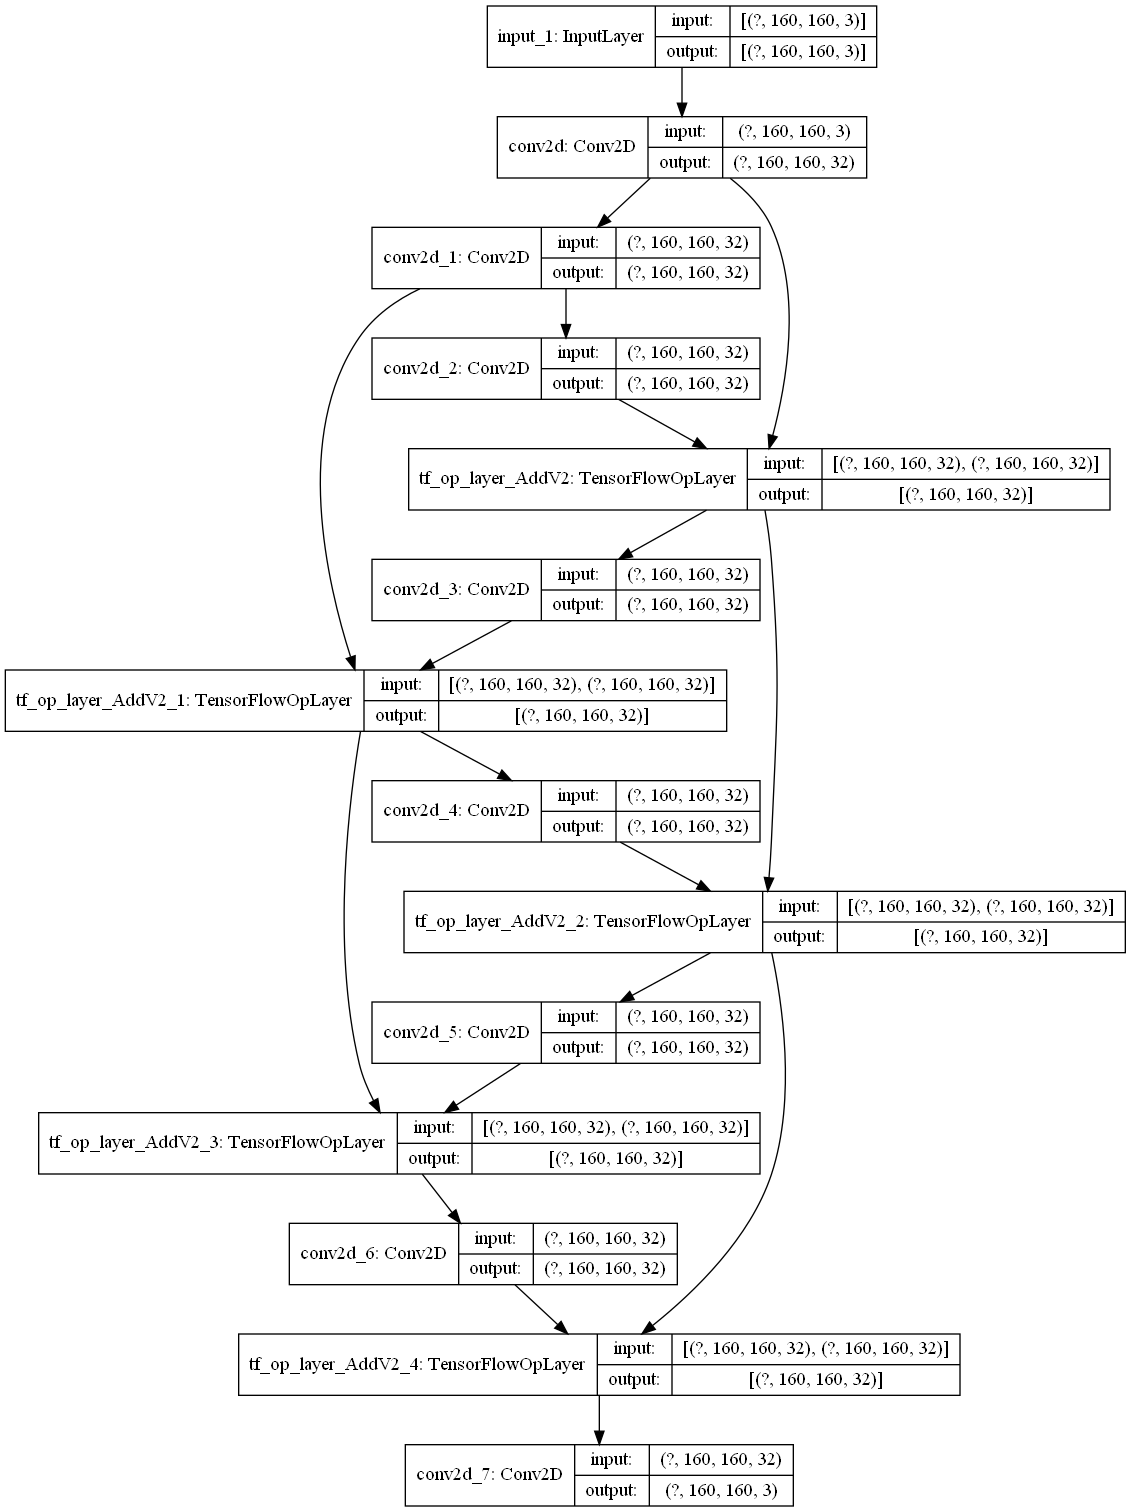

In [6]:
from keras.utils.vis_utils import plot_model
plot_model(model,to_file='model.png',show_shapes=True, show_layer_names=True)

In [7]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint=ModelCheckpoint('models/test2.h5',
                            monitor='val_loss',
                            mode='min',
                            save_best_only=True,
                            verbose=1
                          )
earlystop=EarlyStopping(monitor='val_loss',
                        patience=6,
                        min_delta=0,
                        restore_best_weights=True,
                        verbose=1
                       )
reduce_lr=ReduceLROnPlateau(monitor='val_loss',
                            factor=0.2,
                            patience=6,
                            min_delta=0.001,
                            verbose=1
                           )
callbacks=[checkpoint,earlystop,reduce_lr]

model.compile(loss=keras.losses.MeanSquaredError(),
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy']
             )

history=model.fit(
    x=x_train,
    y=y_train,
    batch_size=8,
    shuffle=True,
    epochs=100,
    validation_data=(x_test, y_test),
    callbacks=callbacks
    )

Epoch 1/100
62/62 [==============================] - ETA: 0s - loss: 0.0455 - accuracy: 0.0017
Epoch 00001: val_loss improved from inf to 0.04061, saving model to models\test2.h5
62/62 [==============================] - 87s 1s/step - loss: 0.0455 - accuracy: 0.0017 - val_loss: 0.0406 - val_accuracy: 0.0013
Epoch 2/100
62/62 [==============================] - ETA: 0s - loss: 0.0330 - accuracy: 0.0017
Epoch 00002: val_loss improved from 0.04061 to 0.02374, saving model to models\test2.h5
62/62 [==============================] - 85s 1s/step - loss: 0.0330 - accuracy: 0.0017 - val_loss: 0.0237 - val_accuracy: 9.8493e-04
Epoch 3/100
 3/62 [>.............................] - ETA: 55s - loss: 0.0355 - accuracy: 5.7129e-04

KeyboardInterrupt: 

In [ ]:
plt.grid()

plt.plot(history.history['loss'],'--^r',label="loss")
plt.plot(history.history['accuracy'],'--^g',label='accuracy')
plt.plot(history.history['val_loss'],'-or',label='val_loss')
plt.plot(history.history['val_accuracy'],'-og',label='val_accuracy')
plt.legend()

In [ ]:
def check_result(n):
    fig=plt.figure()
    fig.add_subplot(1,2,1).imshow(y_test[n])
    fig.add_subplot(1,2,2).imshow(model.predict(x_test)[n])

In [ ]:
check_result(1)